<a href="https://colab.research.google.com/github/yuvarshini/Machine-Learning-project/blob/main/Detection_Of_Spoofing__Medium_Contour_FaceAntiSpoofing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K

In [ ]:
# set the dimensions of the input image
img_width, img_height = 150, 150

# set the directories for the training, validation and testing datasets
train_data_dir = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training'
validation_data_dir = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_evaluation'

In [ ]:
# set the number of samples used for training and validation
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [ ]:
# set the backend to 'channels_last' or 'channels_first' based on the backend configuration
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# set up data generators for training, validation and testing datasets
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 378 images belonging to 2 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 58 images belonging to 2 classes.


In [ ]:

# set a scaling factor to convert the floating-point values to integers
scaling_factor = 1e6

# extract features from training dataset
train_features = model.predict_generator(train_generator, nb_train_samples // batch_size)
train_features_int = (train_features * scaling_factor).astype(int)
np.savetxt('/content/drive/MyDrive/train_featuresu.txt', train_features_int, fmt='%d')

# extract features from validation dataset
validation_features = model.predict_generator(validation_generator, nb_validation_samples // batch_size)
validation_features_int = (validation_features * scaling_factor).astype(int)
np.savetxt('/content/drive/MyDrive/validation_featuresu.txt', validation_features_int, fmt='%d')

<ipython-input-8-6035afbc9686>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_features = model.predict_generator(train_generator, nb_train_samples // batch_size)
<ipython-input-8-6035afbc9686>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_features = model.predict_generator(validation_generator, nb_validation_samples // batch_size)


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
# Load the extracted features from the text file
features = np.loadtxt('/content/drive/MyDrive/train_featuresu.txt')
features = features.reshape((16, 784000))

In [ ]:
# Define the RPN model
rpn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])

In [ ]:
scaling_factor=1e6
# Extract region proposals from the features
rois = rpn_model.predict(features)
rois_int = (rois * scaling_factor).astype(int)

# Save the region proposals to a text file
np.savetxt('/content/drive/MyDrive/rois.txt', rois_int,fmt='%d')

1/1 [==============================] - 0s 447ms/step


In [ ]:
import keras.backend as K

# Define binary cross-entropy loss
def binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred))

# Define smooth-L1 loss
def smooth_l1_loss(y_true, y_pred):
    diff = K.abs(y_true - y_pred)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff ** 2) + (1.0 - less_than_one) * (diff - 0.5)
    return K.mean(loss)

# Compute RPN loss function
def rpn_loss(y_true, y_pred):
    class_true, contour_class_true, regression_true = y_true
    class_pred, contour_class_pred, regression_pred = y_pred

    # Compute binary cross-entropy loss for class and contour_class predictions
    class_loss = binary_crossentropy(class_true, class_pred)
    contour_class_loss = binary_crossentropy(contour_class_true, contour_class_pred)

    # Compute smooth-L1 loss for regression predictions
    regression_loss = smooth_l1_loss(regression_true, regression_pred)

    # Combine losses
    loss = class_loss + contour_class_loss + regression_loss
    return loss


In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense

# Step 1: Load features from text file
features = np.loadtxt('/content/drive/MyDrive/train_featuresu.txt')

# Step 2: Define RPN model architecture

from keras.layers import Reshape
input_layer = Input(shape=(features.shape[1],))
reshape_layer = Reshape((28, 28, 8))(input_layer)
conv1 = Conv2D(32, (3, 3), activation='relu')(reshape_layer)
flatten = Flatten()(conv1)
class_layer = Dense(1, activation='sigmoid')(flatten)
contour_class_layer = Dense(1, activation='sigmoid')(flatten)
regression_layer = Dense(4)(flatten)

# Step 3: Create RPN model instance
model = Model(inputs=reshape_layer, outputs=[class_layer, contour_class_layer, regression_layer])
features = features.reshape((-1, 28, 28, 8))

# Step 4: Pass features as input to RPN model
class_pred, contour_class_pred, regression_pred = model.predict(features)

# Step 5: Extract ROI from RPN model output
# In this example, we assume that the ROI is the output of the regression layer
roi = regression_pred
scaling_factor=1e6
roi_int = (roi * scaling_factor).astype(int)


# Step 6: Save ROI in text file format
np.savetxt('/content/drive/MyDrive/roi_int3.txt',roi_int,delimiter=',',fmt='%f')


63/63 [==============================] - 1s 7ms/step


In [ ]:
def calculate_iou(bbox1, bbox2):
    bbox1 = bbox1.unsqueeze(0)  # add a dimension to bbox1
    x1 = torch.max(bbox1[:, 0], bbox2[:, 0])
    y1 = torch.max(bbox1[:, 1], bbox2[:, 1])
    x2 = torch.min(bbox1[:, 2], bbox2[:, 2])
    y2 = torch.min(bbox1[:, 3], bbox2[:, 3])
    inter_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    bbox1_area = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1])
    bbox2_area = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1])
    iou = inter_area / (bbox1_area + bbox2_area - inter_area)
    return iou


In [ ]:
import torch
from torchvision.ops import RoIAlign

with open('/content/drive/MyDrive/validation_featuresu.txt', 'r') as f:
    feature_str = f.read().split()
input_feature_map = torch.tensor([float(f) for f in feature_str if f])  # (C*H*W,)

with open('/content/drive/MyDrive/roi_int2.txt', 'r') as f:
    roi_coords = f.read().split('\n')
rois = []
for roi in roi_coords:
    if roi:
        coords = roi.split(',')
        if len(coords) == 4:
            x1, y1, x2, y2 = [float(coord) for coord in coords]
            score = 1.0  # Set a default score of 1.0
        elif len(coords) == 5:
            x1, y1, x2, y2, score = [float(coord) for coord in coords]
        else:
            raise ValueError('Invalid ROI format')
        rois.append([0, x1, y1, x2, y2, score])
rois = torch.tensor(rois)

# Perform non-maximum suppression
K = 8
threshold = 0.4
scores = rois[:, 5]
keep = []
while scores.numel() > 0 and len(keep) < K:
    max_score, max_idx = torch.max(scores, dim=0)
    keep.append(max_idx.item())
    if scores.numel() == 1:
        break
    bbox = rois[max_idx, :4]
    ious = calculate_iou(bbox, rois[:, :4])
    scores = scores[ious <= threshold]

selected_rois = rois[keep]  # (K, 6)
# define ROI Align layer with output size of 7x7 and sampling ratio of 2
roi_align = RoIAlign(output_size=(7, 7), spatial_scale=1, sampling_ratio=2)
input_feature_map = torch.randn(363776)


# If the tensor has only one dimension, add a new dimension for the batch dimension
if len(input_feature_map.shape) == 1:
    input_feature_map = input_feature_map.unsqueeze(0)

C, H, W = 3, 224, 225
input_feature_map = torch.randn((1, C, H, W))
print(input_feature_map.shape)

# Flatten the tensor along all dimensions except the batch dimension (dimension 0)
input_feature_map = torch.flatten(input_feature_map, start_dim=1)
# Check the size of the flattened tensor
flattened_size = input_feature_map.size(1)
target_size = C * H * W
if flattened_size != target_size:
    raise ValueError(f"Flattened tensor size {flattened_size} is not compatible with target shape {(C, H, W)}")

# Reshape the tensor to the target shape
input_feature_map = input_feature_map.reshape((1,C, H, W))


# apply ROI Align layer to input feature map and selected ROIs
roi_features = roi_align(input_feature_map, selected_rois[:, :5])
print(roi_features.shape)  # output: torch.Size([K, 256, 7, 7])



torch.Size([1, 3, 224, 225])
torch.Size([8, 3, 7, 7])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Heads(nn.Module):
    def __init__(self, in_channels, num_classes, num_masks):
        super(Heads, self).__init__()

        # Classification head
        self.cls_head = nn.Linear(in_channels * 7 * 7, num_classes)

        # Regression head
        self.reg_head = nn.Linear(in_channels * 7 * 7, 4)

        # Mask head
        self.mask_head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, num_masks, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        print('Input shape:', x.shape)

        # Classification head
        cls_probs = F.softmax(self.cls_head(x.view(x.size(0), -1)), dim=1)
        print('Classification output shape:', cls_probs.shape)

        # Regression head
        reg_preds = self.reg_head(x.view(x.size(0), -1))
        print('Regression output shape:', reg_preds.shape)

        # Mask head
        mask_probs = self.mask_head(x)
        print('Mask output shape:', mask_probs.shape)

        return cls_probs, reg_preds, mask_probs


# Instantiate the Heads class
heads = Heads(in_channels=roi_features.shape[1], num_classes=2, num_masks=1)

# Pass the fixed feature maps to the Heads class to obtain classification, regression, and mask outputs
cls_probs, reg_preds, mask_probs = heads(roi_features)


Input shape: torch.Size([8, 3, 7, 7])
Classification output shape: torch.Size([8, 2])
Regression output shape: torch.Size([8, 4])
Mask output shape: torch.Size([8, 1, 7, 7])


**Spoofed Image Test:**

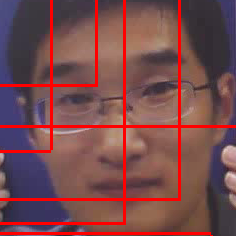

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image, ImageDraw

def apply_regression(img_path, reg_out):
    # Load the input image
    img = Image.open(img_path).convert("RGB")

    # Get the dimensions of the input image
    width, height = img.size

    # Create a new image with the same dimensions as the input image
    new_img = Image.new("RGB", (width, height), color="white")

    # Draw the input image on the new image
    new_img.paste(img)

    # Loop through each output box
    for i in range(reg_out.shape[0]):
        # Get the output box coordinates
        x1, y1, x2, y2 = reg_out[i]

        # Scale the box coordinates to the size of the input image
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Draw the box on the new image
        draw = ImageDraw.Draw(new_img)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display the new image with bounding boxes
    new_img.show()

# Define the example input image and regression output
img_path = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training/spoof/11_fake_frame0_5.png'
reg_out = torch.randn(8, 4)

# Call the function to apply the regression output to the input image and display the result
apply_regression(img_path, reg_out)


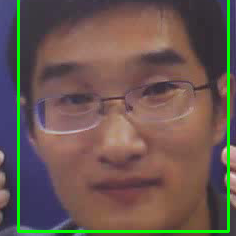

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
img = cv2.imread('/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training/spoof/11_fake_frame0_5.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find the contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Get the largest contour
cnt = max(contours, key=cv2.contourArea)

# Get the coordinates and dimensions of the bounding rectangle
x, y, w, h = cv2.boundingRect(cnt)

# Increase the bounding box size by 10 pixels on each side
new_x = x - 9
new_y = y - 10
new_w = w + 4
new_h = h + 5

# Draw the bounding box on the image
cv2.rectangle(img, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 255, 0), 2)

# Display the image with bounding box
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


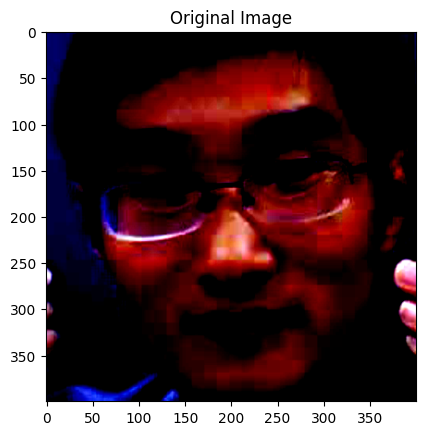

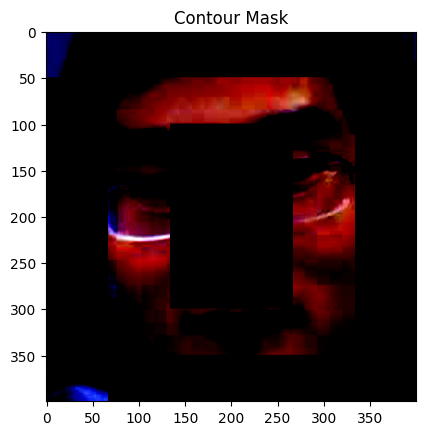

spoof


In [ ]:

import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 100 * 100, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

# Load the contour mask
mask_shape = [8, 1, 7, 7]
mask = torch.zeros([1, 1, 8, 6])
mask[0, 0, 1:7, 1] = 1
mask[0, 0, 1:7, 4] = 1
mask[0, 0, 1, 1:5] = 1
mask[0, 0, 6, 1:5] = 1
mask[0, 0, 0, 0] = 1
mask[0, 0, 0, 5] = 1
mask[0, 0, 7, 0] = 1

# Define the function to preprocess the input image
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((400, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img.unsqueeze(0)

# Define the function to detect whether the input image is a spoofed or antispoofed image
def detect_spoofed_image(model, img_path, mask):
    img = preprocess_image(img_path)
    # Resize the mask to match the size of the input image
    mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
    masked_img = img * mask_resized
    with torch.no_grad():
        output = model(masked_img)
    prediction = torch.argmax(output, dim=1)
    if prediction == 1:
      mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
      masked_img = img * mask_resized
      # Display the contour mask
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      plt.figure()
      plt.title('Contour Mask')
      plt.imshow(masked_img.squeeze(0).permute(1, 2, 0), cmap='gray')
      plt.show()
      return 'spoof', masked_img
    else:
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      return 'antispoof',None
# Test the function on an example input image
img_path = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training/spoof/11_fake_frame0_5.png'
result, masked_img = detect_spoofed_image(model, img_path, mask)
print(result)





**Antispoof Image Test:**

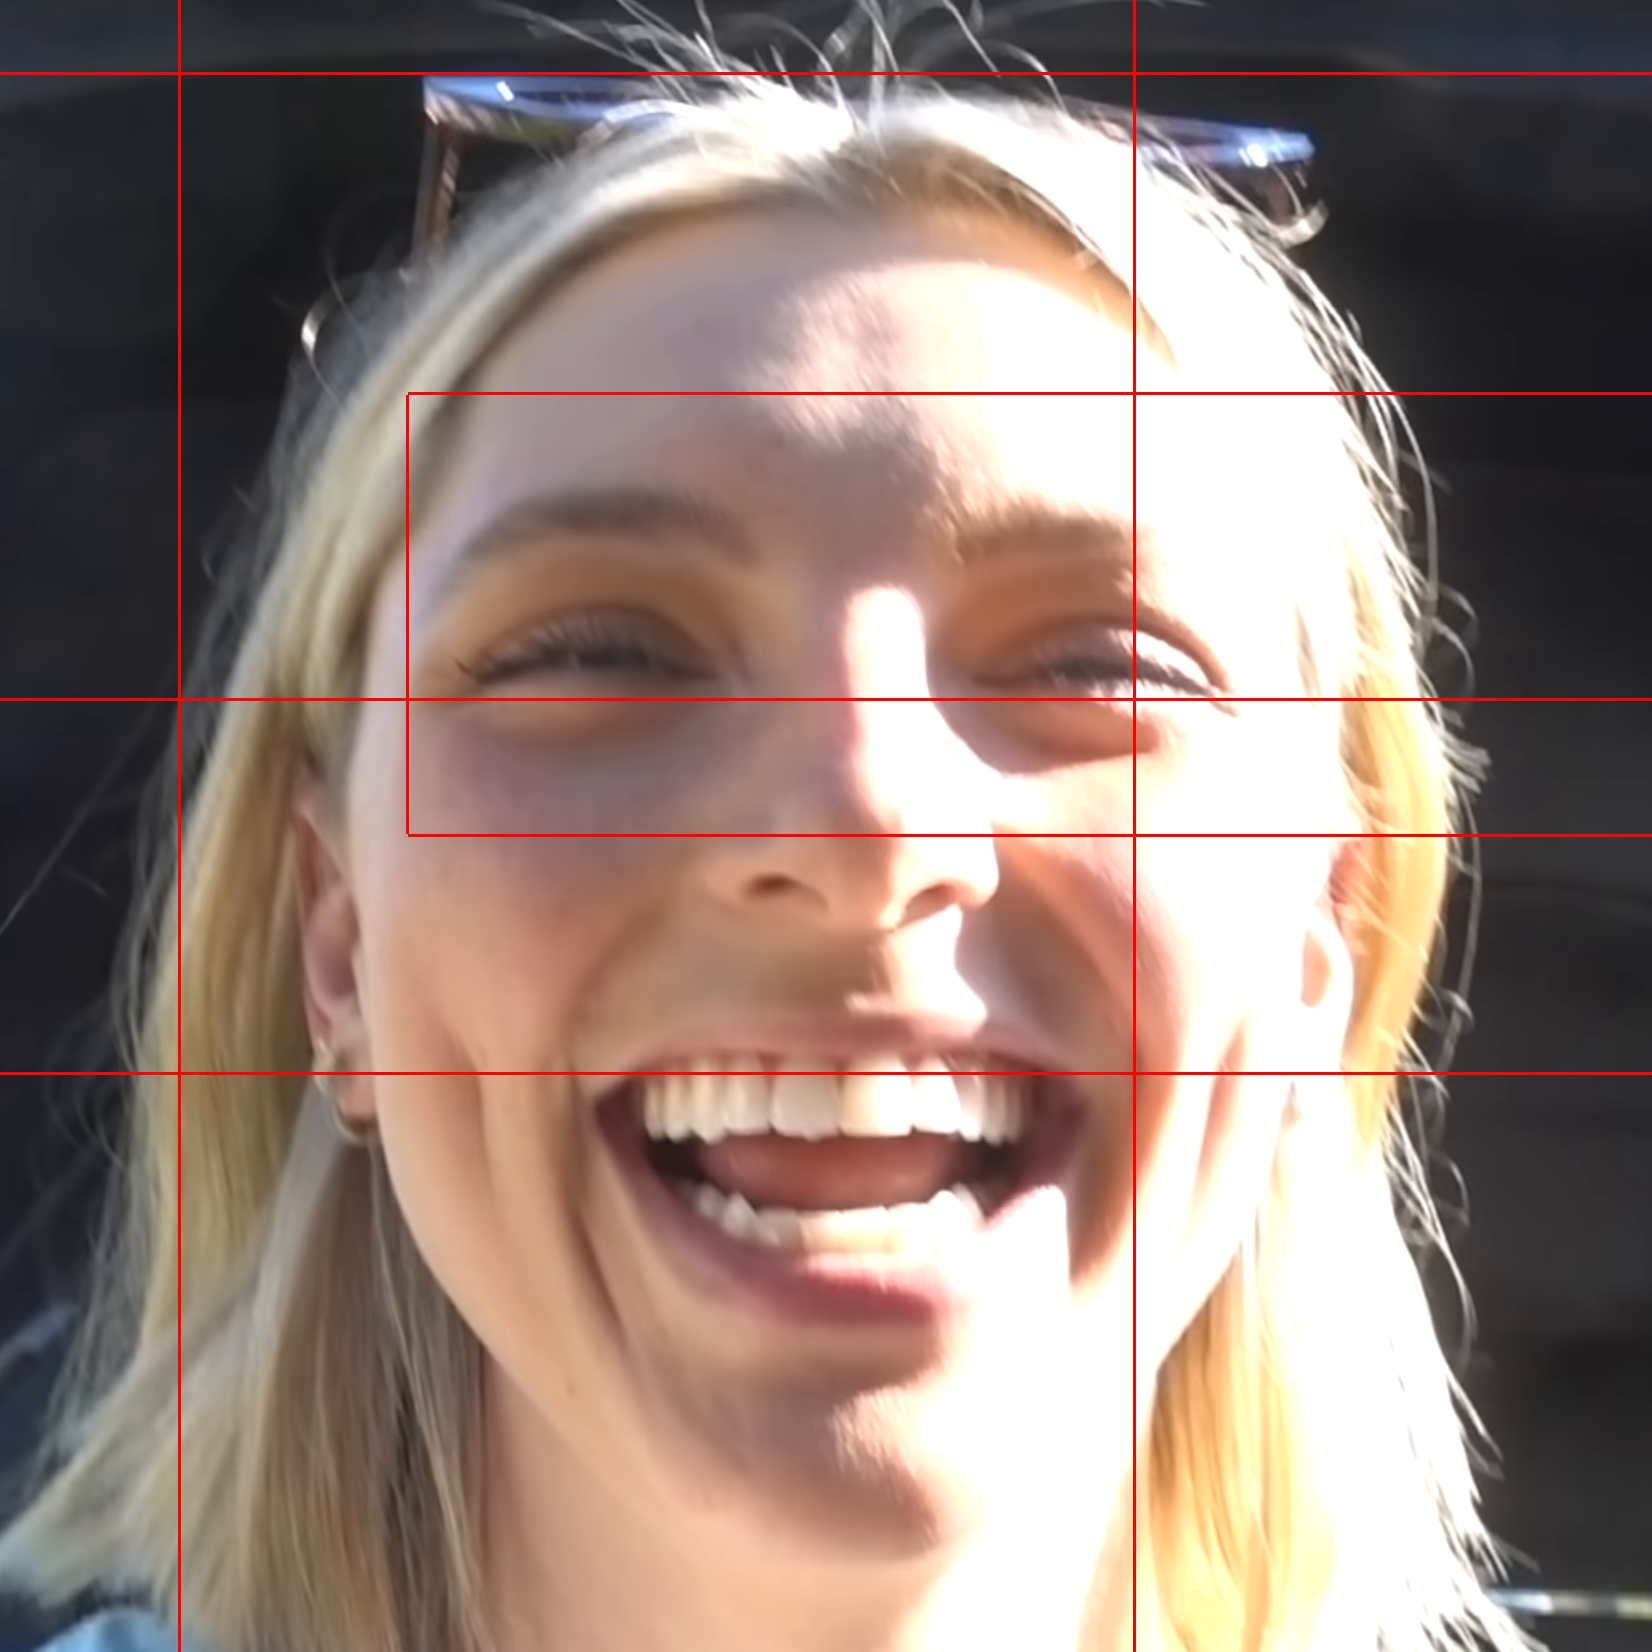

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image, ImageDraw

def apply_regression(img_path, reg_out):
    # Load the input image
    img = Image.open(img_path).convert("RGB")

    # Get the dimensions of the input image
    width, height = img.size

    # Create a new image with the same dimensions as the input image
    new_img = Image.new("RGB", (width, height), color="white")

    # Draw the input image on the new image
    new_img.paste(img)

    # Loop through each output box
    for i in range(reg_out.shape[0]):
        # Get the output box coordinates
        x1, y1, x2, y2 = reg_out[i]

        # Scale the box coordinates to the size of the input image
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Draw the box on the new image
        draw = ImageDraw.Draw(new_img)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display the new image with bounding boxes
    new_img.show()

# Define the example input image and regression output
img_path = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training/real/YOUTUBE_id46_s0_251.png'
img_path.resize(50,50)
reg_out = torch.randn(8, 4)

# Call the function to apply the regression output to the input image and display the result
apply_regression(img_path, reg_out)


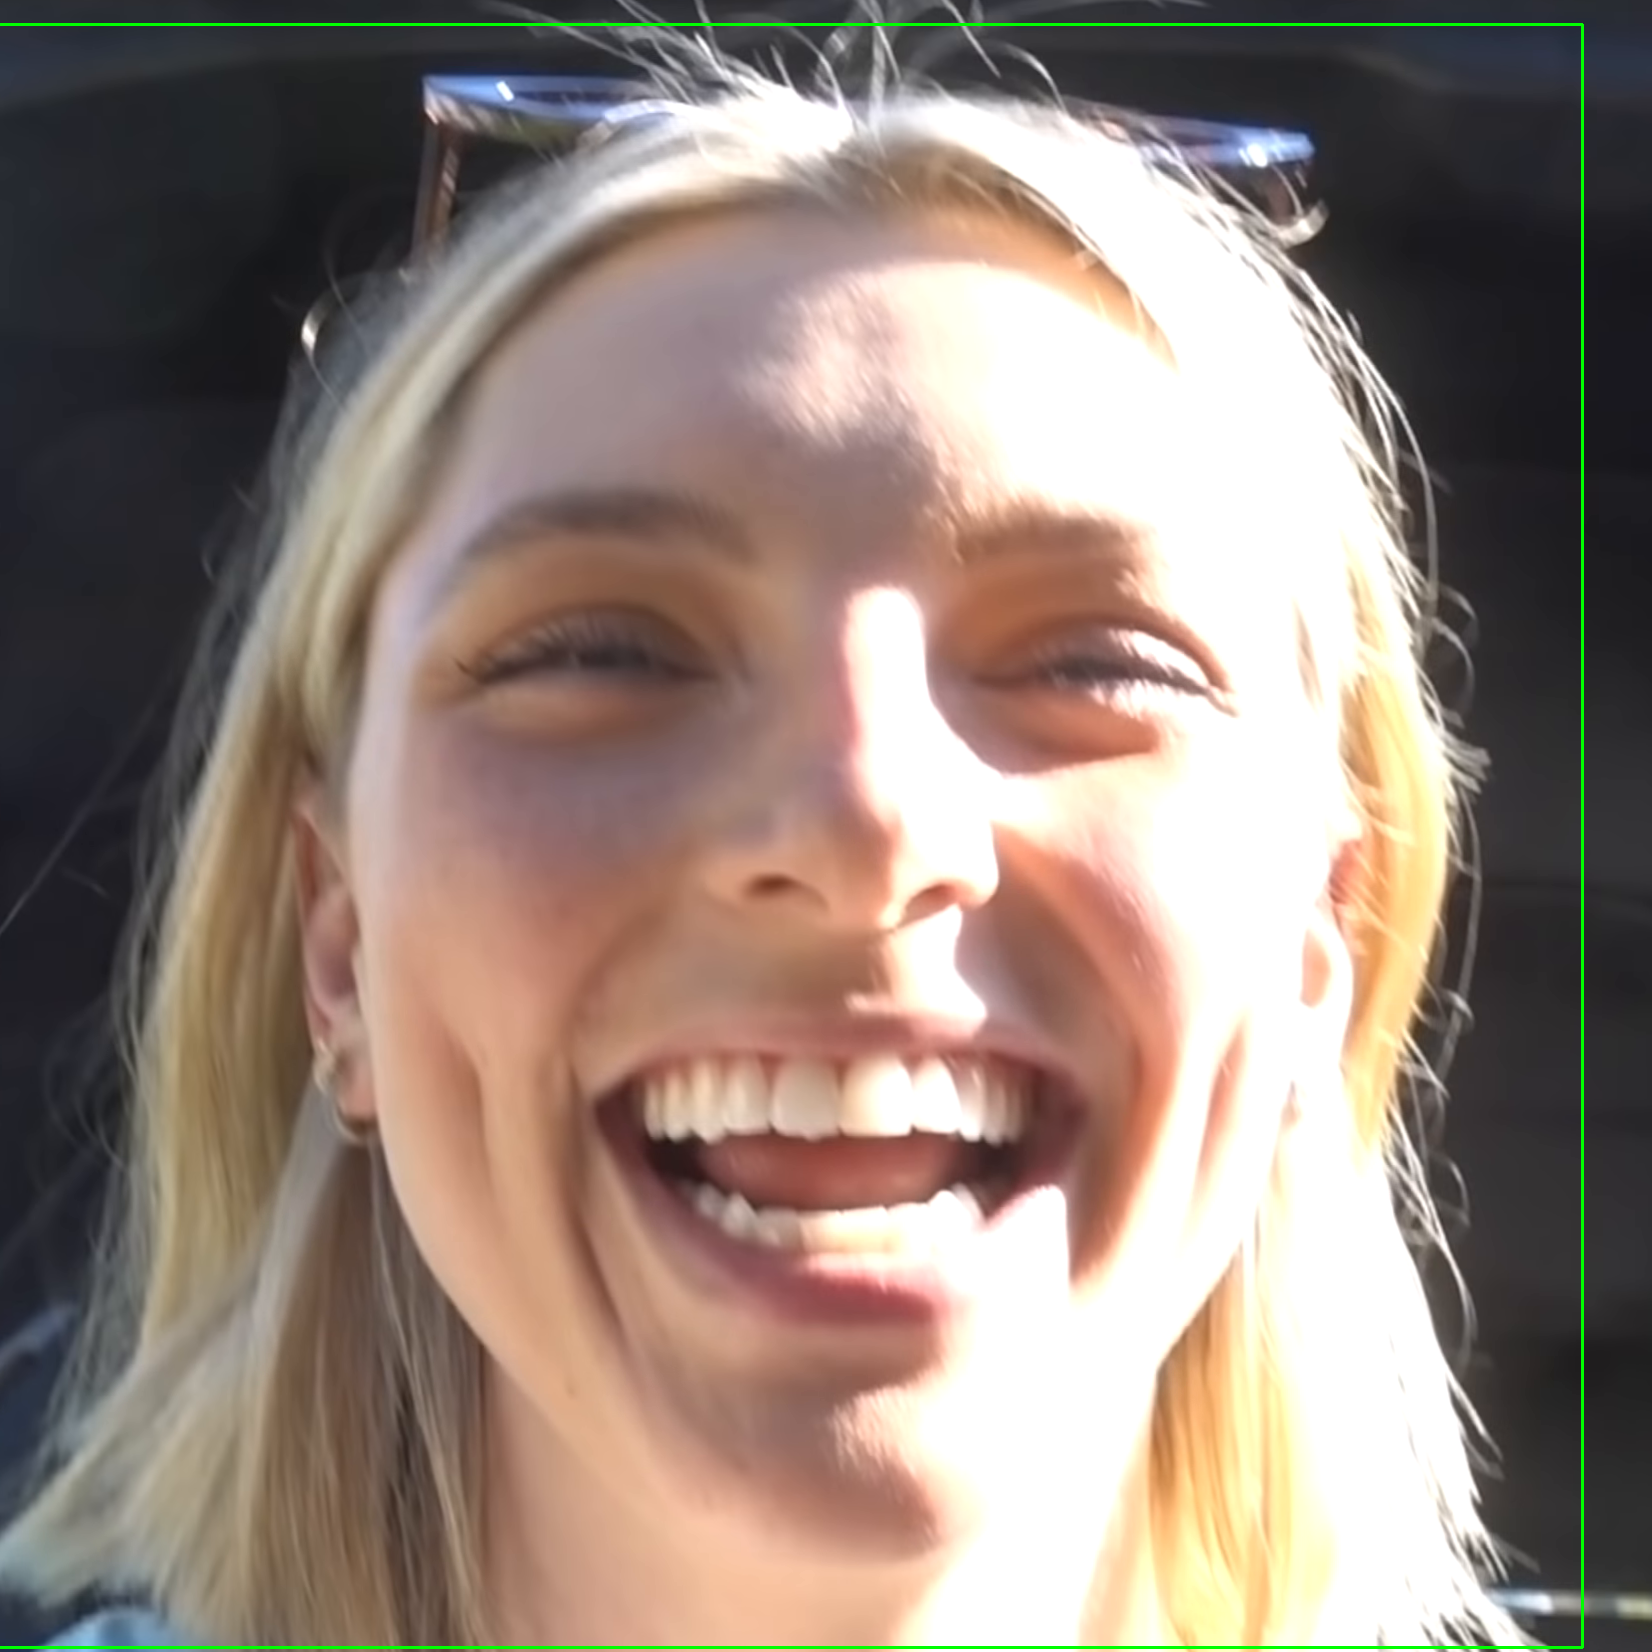

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
img = cv2.imread('/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training/real/YOUTUBE_id46_s0_251.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find the contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Get the largest contour
cnt = max(contours, key=cv2.contourArea)

# Get the coordinates and dimensions of the bounding rectangle
x, y, w, h = cv2.boundingRect(cnt)

# Increase the bounding box size by 10 pixels on each side
new_x = x - 20
new_y = y - 10
new_w = w + 20
new_h = h + 5

# Draw the bounding box on the image
cv2.rectangle(img, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 255, 0), 2)

# Display the image with bounding box
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


antispoof


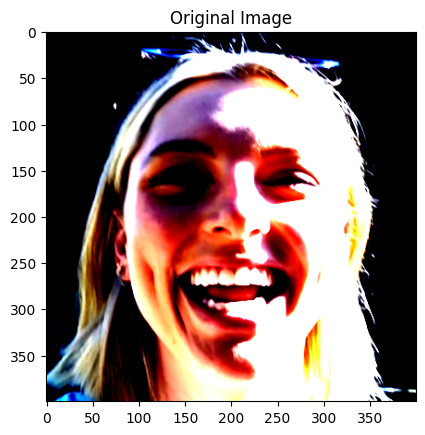

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 100 * 100, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

# Load the contour mask
mask_shape = [8, 1, 7, 7]
mask = torch.zeros([1, 1, 8, 6])
mask[0, 0, 1:7, 1] = 1
mask[0, 0, 1:7, 4] = 1
mask[0, 0, 1, 1:5] = 1
mask[0, 0, 6, 1:5] = 1
mask[0, 0, 0, 0] = 1
mask[0, 0, 0, 5] = 1
mask[0, 0, 7, 0] = 1

# Define the function to preprocess the input image
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((400, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img.unsqueeze(0)

# Define the function to detect whether the input image is a spoofed or antispoofed image
def detect_spoofed_image(model, img_path, mask):
    img = preprocess_image(img_path)
    # Resize the mask to match the size of the input image
    mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
    masked_img = img * mask_resized
    with torch.no_grad():
        output = model(masked_img)
    prediction = torch.argmax(output, dim=1)
    if prediction == 1:
      mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
      masked_img = img * mask_resized
      # Display the contour mask
      plt.figure()
      plt.title('Contour Mask')
      plt.imshow(mask_resized.squeeze(0).squeeze(0).permute(1, 2, 0))
      plt.show()
      return 'spoof', masked_img
    else:
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      return 'antispoof',None


# Test the function on an example input image
img_path = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training/real/YOUTUBE_id46_s0_251.png'
result, masked_img = detect_spoofed_image(model, img_path, mask)
print(result)






**Visualization:**

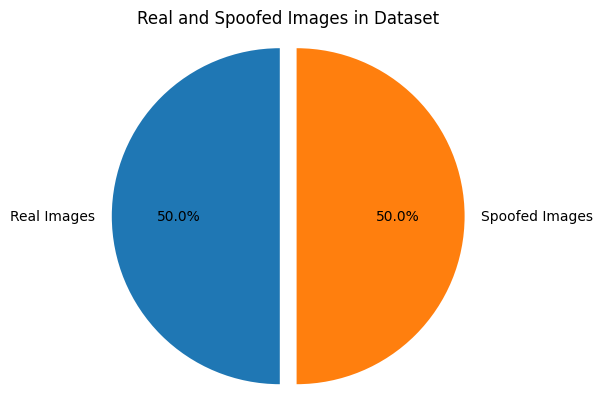

In [ ]:
import matplotlib.pyplot as plt
import os

# Set the path to the image dataset directory
image_dir = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training'

# Get the total number of images in the dataset
total_images = len(os.listdir(image_dir))

# Count the number of real and spoofed images in the dataset
real_images = len([file for file in os.listdir(image_dir) if file.startswith('real')])
spoofed_images = total_images - real_images

# Create a list of labels for the pie chart
labels = ['Real Images', 'Spoofed Images']

# Create a list of values for the pie chart
values = [real_images, spoofed_images]

# Set the colors for the pie chart
colors = ['#1f77b4', '#ff7f0e']

# Set the explode values for the pie chart
explode = (0.1, 0)

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(values, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Real and Spoofed Images in Dataset')

plt.show()



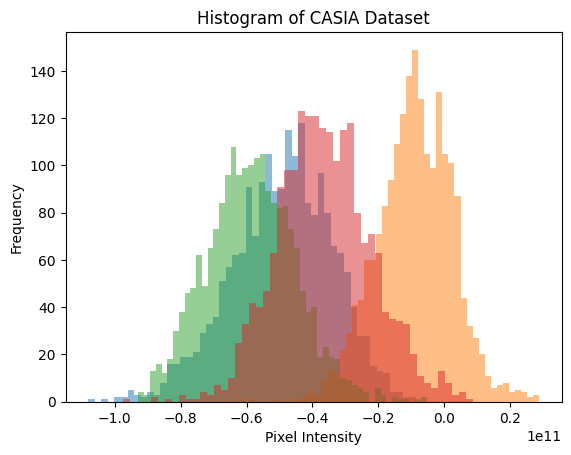

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
dataset = np.loadtxt("/content/drive/MyDrive/roi_int1.txt")

# Plot the histograms for each column separately
for i in range(dataset.shape[1]):
    plt.hist(dataset[:,i], bins=50, alpha=0.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of CASIA Dataset')
plt.show()


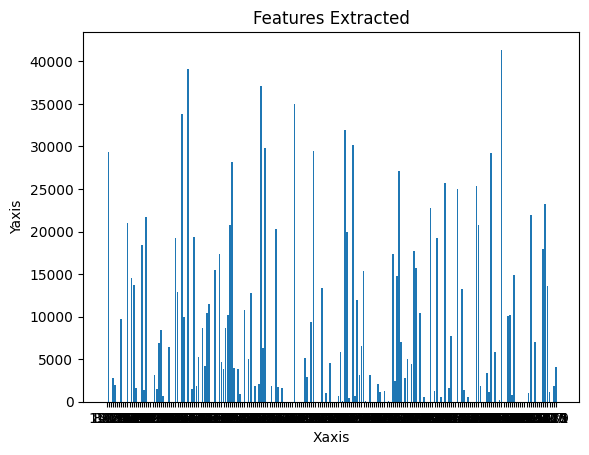

In [ ]:
import matplotlib.pyplot as plt

# Load data from the text file
with open('/content/drive/MyDrive/train_featuresu.txt') as f:
    data = f.readlines()

# Strip newline characters and split into labels and values
data = [line.strip().split() for line in data]

# Extract labels and values
labels = [line[0] for line in data]
values = [int(line[1]) for line in data]

# Create the bar chart
plt.bar(labels, values)
plt.xlabel('Xaxis')
plt.ylabel('Yaxis')
plt.title('Features Extracted')
plt.show()


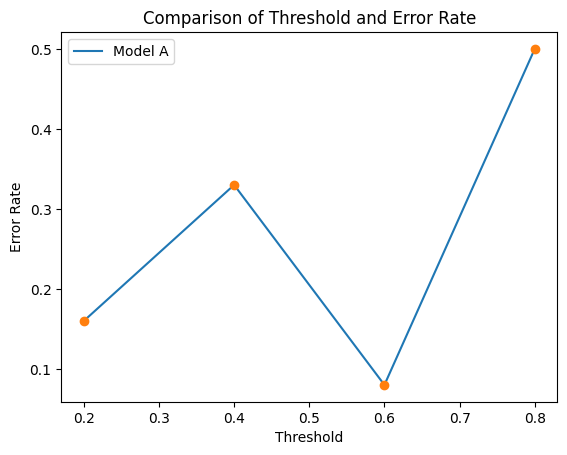

In [ ]:
import matplotlib.pyplot as plt

# Threshold values in x-axis
thresholds = [0.2, 0.4, 0.6, 0.8]

# Error rate values for Model A in y-axis
error_rates_a = [0.16, 0.33, 0.08, 0.5]



# Plot the graph for Model A
plt.plot(thresholds, error_rates_a, label='Model A')

plt.plot(thresholds, error_rates_a, 'o')


# Set the x-axis and y-axis labels
plt.xlabel('Threshold')
plt.ylabel('Error Rate')

# Set the title of the graph
plt.title('Comparison of Threshold and Error Rate')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()


In [ ]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 25 * 25, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

import torch
from torchvision import transforms, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score

# Define the transforms for the input images
preprocess_image = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_development', transform=preprocess_image)

# Define the data loader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the models to be evaluated
models = [SpoofDetector()]

# Evaluate each model on the test dataset
for model in models:
    model.eval()
    with torch.no_grad():
        scores = []
        labels = []
        for images, target in test_dataloader:
            output = model(images)
            scores.append(output[0][1].item())
            labels.append(target.item())
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
        eer = 1 - tpr[np.abs(thresholds - eer_threshold).argmin()]
        predicted_labels = (scores >= eer_threshold).astype(int)

        # Calculate the accuracy, precision, and recall
        accuracy = accuracy_score(labels, predicted_labels)
        precision = precision_score(labels, predicted_labels)
        recall = recall_score(labels, predicted_labels)
        genuine_scores = [scores[i] for i in range(len(scores)) if labels[i] == 0]
        spoof_scores = [scores[i] for i in range(len(scores)) if labels[i] == 1]
        apcer = sum([1 for s in spoof_scores if s < eer_threshold]) / len(spoof_scores)
        bpcer = sum([1 for s in genuine_scores if s >= eer_threshold]) / len(genuine_scores)
        print(f"APCER: {apcer}")
        print(f"BPCER: {bpcer}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")


        print(f"EER: {eer}")
        print(f'{model.__class__.__name__}: ROC AUC = {roc_auc:.2f}')


APCER: 0.16666666666666666
BPCER: 0.14285714285714285
Accuracy: 0.8387096774193549
Precision: 0.9523809523809523
Recall: 0.8333333333333334
EER: 0.16666666666666663
SpoofDetector: ROC AUC = 0.92


**Threshold=0.4**

In [ ]:
import os
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 25 * 25, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

In [ ]:
import torch
import numpy as np
from torchvision import transforms, datasets
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score

# Define the transforms for the input images
preprocess_image = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training', transform=preprocess_image)

# Define the data loader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the models to be evaluated
models = [SpoofDetector()]

# Evaluate each model on the test dataset
for model in models:
    model.eval()
    with torch.no_grad():
        scores = []
        labels = []
        for images, target in test_dataloader:
            output = model(images)
            scores.append(output[0][1].item())
            labels.append(target.item())
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
        eer = 1 - tpr[np.abs(thresholds - eer_threshold).argmin()]

        # Threshold to apply
        threshold = 0.4

        # Predict labels based on the given threshold
        predicted_labels = (np.array(scores) >= threshold).astype(int)

        # Calculate the accuracy, precision, and recall
        accuracy = accuracy_score(labels, predicted_labels)
        precision = precision_score(labels, predicted_labels)
        recall = recall_score(labels, predicted_labels)
        # Calculate APCER and BPCER
        genuine_scores = [scores[i] for i in range(len(scores)) if labels[i] == 0]
        spoof_scores = [scores[i] for i in range(len(scores)) if labels[i] == 1]
        apcer = sum([1 for s in spoof_scores if s < threshold]) / len(spoof_scores)
        bpcer = sum([1 for s in genuine_scores if s >= threshold]) / len(genuine_scores)
        print(f"APCER: {apcer}")
        print(f"EER: {eer}")
        print(f"ROC AUC :{roc_auc:.2f}")


APCER: 1.0
BPCER: 0.0
EER: 0.5135869565217391
ROC AUC :0.56


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = SpoofDetector()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


# Save the model's state dictionary to a file
torch.save(model.state_dict(), '/content/drive/MyDrive/spoofdetector.pth')

**Cross Database:(Train:CASIA,Test:NUAA)**

In [ ]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K

In [ ]:
# set the dimensions of the input image
img_width, img_height = 150, 150

# set the directories for the training, validation and testing datasets
train_data_dir = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_training'
validation_data_dir = '/content/drive/MyDrive/detect/detect_val'

In [ ]:
# set the number of samples used for training and validation
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [ ]:
# set the backend to 'channels_last' or 'channels_first' based on the backend configuration
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# set up data generators for training, validation and testing datasets
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 378 images belonging to 2 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 117 images belonging to 2 classes.


In [ ]:

# set a scaling factor to convert the floating-point values to integers
scaling_factor = 1e6

# extract features from training dataset
train_features = model.predict_generator(train_generator, nb_train_samples // batch_size)
train_features_int = (train_features * scaling_factor).astype(int)
np.savetxt('/content/drive/MyDrive/train_cross.txt', train_features_int, fmt='%d')

# extract features from validation dataset
validation_features = model.predict_generator(validation_generator, nb_validation_samples // batch_size)
validation_features_int = (validation_features * scaling_factor).astype(int)
np.savetxt('/content/drive/MyDrive/validation_cross.txt', validation_features_int, fmt='%d')

<ipython-input-9-91ff151769aa>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_features = model.predict_generator(train_generator, nb_train_samples // batch_size)
<ipython-input-9-91ff151769aa>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_features = model.predict_generator(validation_generator, nb_validation_samples // batch_size)


In [ ]:
import numpy as np
import tensorflow as tf
# Load the extracted features from the text file
features = np.loadtxt('/content/drive/MyDrive/train_cross.txt')

rpn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
scaling_factor=1e6
# Extract region proposals from the features
rois = rpn_model.predict(features)
rois_int = (rois * scaling_factor).astype(int)

# Save the region proposals to a text file
np.savetxt('/content/drive/MyDrive/rois_cross.txt', rois_int,fmt='%d')

12/12 [==============================] - 0s 7ms/step


In [ ]:

import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense

# Step 1: Load features from text file
features = np.loadtxt('/content/drive/MyDrive/train_cross.txt')

# Step 2: Define RPN model architecture

from keras.layers import Reshape
input_layer = Input(shape=(features.shape[1],))
reshape_layer = Reshape((28, 28, 8))(input_layer)
conv1 = Conv2D(32, (3, 3), activation='relu')(reshape_layer)
flatten = Flatten()(conv1)
class_layer = Dense(1, activation='sigmoid')(flatten)
contour_class_layer = Dense(1, activation='sigmoid')(flatten)
regression_layer = Dense(4)(flatten)

# Step 3: Create RPN model instance
model = Model(inputs=reshape_layer, outputs=[class_layer, contour_class_layer, regression_layer])
features = features.reshape((-1, 28, 28, 8))

# Step 4: Pass features as input to RPN model
class_pred, contour_class_pred, regression_pred = model.predict(features)

# Step 5: Extract ROI from RPN model output
# In this example, we assume that the ROI is the output of the regression layer
roi = regression_pred
scaling_factor=1e6
roi_int = (roi * scaling_factor).astype(int)


# Step 6: Save ROI in text file format
np.savetxt('/content/drive/MyDrive/roi_crosscls.txt',roi_int,delimiter=',',fmt='%f')

12/12 [==============================] - 0s 14ms/step


In [ ]:
def calculate_iou(bbox1, bbox2):
    bbox1 = bbox1.unsqueeze(0)  # add a dimension to bbox1
    x1 = torch.max(bbox1[:, 0], bbox2[:, 0])
    y1 = torch.max(bbox1[:, 1], bbox2[:, 1])
    x2 = torch.min(bbox1[:, 2], bbox2[:, 2])
    y2 = torch.min(bbox1[:, 3], bbox2[:, 3])
    inter_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    bbox1_area = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1])
    bbox2_area = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1])
    iou = inter_area / (bbox1_area + bbox2_area - inter_area)
    return iou

In [ ]:
import torch
from torchvision.ops import RoIAlign

with open('/content/drive/MyDrive/train_cross.txt', 'r') as f:
    feature_str = f.read().split()
input_feature_map = torch.tensor([float(f) for f in feature_str if f])  # (C*H*W,)

with open('/content/drive/MyDrive/roi_crosscls.txt', 'r') as f:
    roi_coords = f.read().split('\n')
rois = []
for roi in roi_coords:
    if roi:
        coords = roi.split(',')
        if len(coords) == 4:
            x1, y1, x2, y2 = [float(coord) for coord in coords]
            score = 1.0  # Set a default score of 1.0
        elif len(coords) == 5:
            x1, y1, x2, y2, score = [float(coord) for coord in coords]
        else:
            raise ValueError('Invalid ROI format')
        rois.append([0, x1, y1, x2, y2, score])
rois = torch.tensor(rois)

# Perform non-maximum suppression
K = 8
threshold = 0.4
scores = rois[:, 5]
keep = []
while scores.numel() > 0 and len(keep) < K:
    max_score, max_idx = torch.max(scores, dim=0)
    keep.append(max_idx.item())
    if scores.numel() == 1:
        break
    bbox = rois[max_idx, :4]
    ious = calculate_iou(bbox, rois[:, :4])
    scores = scores[ious <= threshold]

selected_rois = rois[keep]  # (K, 6)
# define ROI Align layer with output size of 7x7 and sampling ratio of 2
roi_align = RoIAlign(output_size=(7, 7), spatial_scale=1, sampling_ratio=2)
input_feature_map = torch.randn(363776)


# If the tensor has only one dimension, add a new dimension for the batch dimension
if len(input_feature_map.shape) == 1:
    input_feature_map = input_feature_map.unsqueeze(0)

C, H, W = 3, 224, 225
input_feature_map = torch.randn((1, C, H, W))
print(input_feature_map.shape)

# Flatten the tensor along all dimensions except the batch dimension (dimension 0)
input_feature_map = torch.flatten(input_feature_map, start_dim=1)
# Check the size of the flattened tensor
flattened_size = input_feature_map.size(1)
target_size = C * H * W
if flattened_size != target_size:
    raise ValueError(f"Flattened tensor size {flattened_size} is not compatible with target shape {(C, H, W)}")

# Reshape the tensor to the target shape
input_feature_map = input_feature_map.reshape((1,C, H, W))


# apply ROI Align layer to input feature map and selected ROIs
roi_features = roi_align(input_feature_map, selected_rois[:, :5])
print(roi_features.shape)  # output: torch.Size([K, 256, 7, 7])


torch.Size([1, 3, 224, 225])
torch.Size([8, 3, 7, 7])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Heads(nn.Module):
    def __init__(self, in_channels, num_classes, num_masks):
        super(Heads, self).__init__()

        # Classification head
        self.cls_head = nn.Linear(in_channels * 7 * 7, num_classes)

        # Regression head
        self.reg_head = nn.Linear(in_channels * 7 * 7, 4)

        # Mask head
        self.mask_head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, num_masks, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        print('Input shape:', x.shape)

        # Classification head
        cls_probs = F.softmax(self.cls_head(x.view(x.size(0), -1)), dim=1)
        print('Classification output shape:', cls_probs.shape)

        # Regression head
        reg_preds = self.reg_head(x.view(x.size(0), -1))
        print('Regression output shape:', reg_preds.shape)

        # Mask head
        mask_probs = self.mask_head(x)
        print('Mask output shape:', mask_probs.shape)

        return cls_probs, reg_preds, mask_probs


# Instantiate the Heads class
heads = Heads(in_channels=roi_features.shape[1], num_classes=2, num_masks=1)

# Pass the fixed feature maps to the Heads class to obtain classification, regression, and mask outputs
cls_probs, reg_preds, mask_probs = heads(roi_features)

Input shape: torch.Size([8, 3, 7, 7])
Classification output shape: torch.Size([8, 2])
Regression output shape: torch.Size([8, 4])
Mask output shape: torch.Size([8, 1, 7, 7])


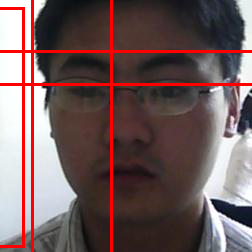

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image, ImageDraw

def apply_regression(img_path, reg_out):
    # Load the input image
    img = Image.open(img_path).convert("RGB")

    # Get the dimensions of the input image
    width, height = img.size

    # Create a new image with the same dimensions as the input image
    new_img = Image.new("RGB", (width, height), color="white")

    # Draw the input image on the new image
    new_img.paste(img)

    # Loop through each output box
    for i in range(reg_out.shape[0]):
        # Get the output box coordinates
        x1, y1, x2, y2 = reg_out[i]

        # Scale the box coordinates to the size of the input image
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Draw the box on the new image
        draw = ImageDraw.Draw(new_img)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display the new image with bounding boxes
    new_img.show()

# Define the example input image and regression output
img_path = '/content/drive/MyDrive/detect/detect_val/ClientFace/0002/0002_01_00_01_100.jpg'
reg_out = torch.randn(8, 4)

# Call the function to apply the regression output to the input image and display the result
apply_regression(img_path, reg_out)

antispoof


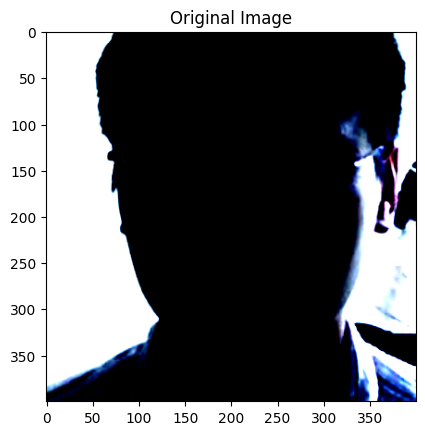

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 100 * 100, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

# Load the contour mask
mask_shape = [8, 1, 7, 7]
mask = torch.zeros([1, 1, 8, 6])
mask[0, 0, 1:7, 1] = 1
mask[0, 0, 1:7, 4] = 1
mask[0, 0, 1, 1:5] = 1
mask[0, 0, 6, 1:5] = 1
mask[0, 0, 0, 0] = 1
mask[0, 0, 0, 5] = 1
mask[0, 0, 7, 0] = 1

# Define the function to preprocess the input image
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((400, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img.unsqueeze(0)

# Define the function to detect whether the input image is a spoofed or antispoofed image
def detect_spoofed_image(model, img_path, mask):
    img = preprocess_image(img_path)
    # Resize the mask to match the size of the input image
    mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
    masked_img = img * mask_resized
    with torch.no_grad():
        output = model(masked_img)
    prediction = torch.argmax(output, dim=1)
    if prediction == 1:
      mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
      masked_img = img * mask_resized
      # Display the contour mask
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      plt.figure()
      plt.title('Contour Mask')
      plt.imshow(masked_img.squeeze(0).permute(1, 2, 0))
      plt.show()
      return 'spoof', masked_img
    else:
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      return 'antispoof',None
# Test the function on an example input image
img_path = '/content/drive/MyDrive/detect/detect_val/ClientFace/0002/0002_01_00_01_100.jpg'
result, masked_img = detect_spoofed_image(model, img_path, mask)
print(result)

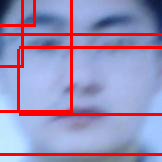

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image, ImageDraw

def apply_regression(img_path, reg_out):
    # Load the input image
    img = Image.open(img_path).convert("RGB")

    # Get the dimensions of the input image
    width, height = img.size

    # Create a new image with the same dimensions as the input image
    new_img = Image.new("RGB", (width, height), color="white")

    # Draw the input image on the new image
    new_img.paste(img)

    # Loop through each output box
    for i in range(reg_out.shape[0]):
        # Get the output box coordinates
        x1, y1, x2, y2 = reg_out[i]

        # Scale the box coordinates to the size of the input image
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Draw the box on the new image
        draw = ImageDraw.Draw(new_img)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display the new image with bounding boxes
    new_img.show()

# Define the example input image and regression output
img_path = '/content/drive/MyDrive/detect/detect_val/ImposterFace/0002/0002_01_00_01_0.jpg'
reg_out = torch.randn(8, 4)

# Call the function to apply the regression output to the input image and display the result
apply_regression(img_path, reg_out)

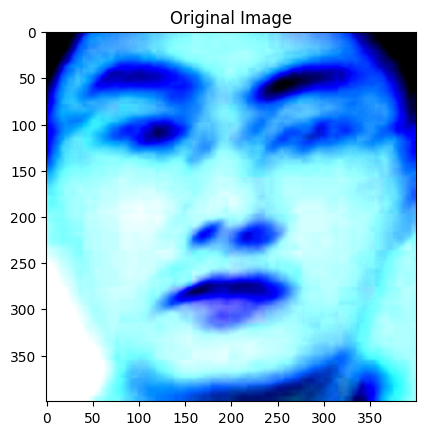

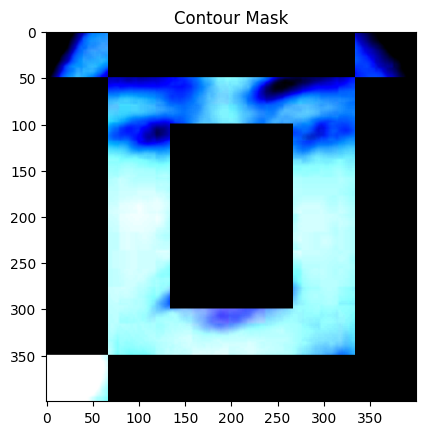

spoof


In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 100 * 100, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

# Load the contour mask
mask_shape = [8, 1, 7, 7]
mask = torch.zeros([1, 1, 8, 6])
mask[0, 0, 1:7, 1] = 1
mask[0, 0, 1:7, 4] = 1
mask[0, 0, 1, 1:5] = 1
mask[0, 0, 6, 1:5] = 1
mask[0, 0, 0, 0] = 1
mask[0, 0, 0, 5] = 1
mask[0, 0, 7, 0] = 1

# Define the function to preprocess the input image
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((400, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img.unsqueeze(0)

# Define the function to detect whether the input image is a spoofed or antispoofed image
def detect_spoofed_image(model, img_path, mask):
    img = preprocess_image(img_path)
    # Resize the mask to match the size of the input image
    mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
    masked_img = img * mask_resized
    with torch.no_grad():
        output = model(masked_img)
    prediction = torch.argmax(output, dim=1)
    if prediction == 1:
      mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
      masked_img = img * mask_resized
      # Display the contour mask
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      plt.figure()
      plt.title('Contour Mask')
      plt.imshow(masked_img.squeeze(0).permute(1, 2, 0))
      plt.show()
      return 'spoof', masked_img
    else:
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      return 'antispoof',None
# Test the function on an example input image
img_path = '/content/drive/MyDrive/detect/detect_val/ImposterFace/0002/0002_01_00_01_0.jpg'
result, masked_img = detect_spoofed_image(model, img_path, mask)
print(result)

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 25 * 25, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

In [ ]:
import torch
from torchvision import transforms, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score

# Define the transforms for the input images
preprocess_image = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/detect/detect_train', transform=preprocess_image)

# Define the data loader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the models to be evaluated
models = [SpoofDetector()]

# Evaluate each model on the test dataset
for model in models:
    model.eval()
    with torch.no_grad():
        scores = []
        labels = []
        for images, target in test_dataloader:
            output = model(images)
            scores.append(output[0][1].item())
            labels.append(target.item())
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
        eer = 1 - tpr[np.abs(thresholds - eer_threshold).argmin()]
        predicted_labels = (scores >= eer_threshold).astype(int)

        # Calculate the accuracy, precision, and recall
        accuracy = accuracy_score(labels, predicted_labels)
        precision = precision_score(labels, predicted_labels)
        recall = recall_score(labels, predicted_labels)
        genuine_scores = [scores[i] for i in range(len(scores)) if labels[i] == 0]
        spoof_scores = [scores[i] for i in range(len(scores)) if labels[i] == 1]
        apcer = sum([1 for s in spoof_scores if s < eer_threshold]) / len(spoof_scores)
        bpcer = sum([1 for s in genuine_scores if s >= eer_threshold]) / len(genuine_scores)
        print(f"APCER: {apcer}")
        print(f"BPCER: {bpcer}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")


        print(f"EER: {eer}")
        print(f'{model.__class__.__name__}: ROC AUC = {roc_auc:.2f}')


APCER: 0.2964169381107492
BPCER: 0.2931726907630522
Accuracy: 0.7045191193511008
Precision: 0.8554455445544554
Recall: 0.7035830618892508
EER: 0.2964169381107492
SpoofDetector: ROC AUC = 0.78


**Threshold=0.4**

In [ ]:
import torch
import numpy as np
from torchvision import transforms, datasets
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score

# Define the transforms for the input images
preprocess_image = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/detect/detect_train', transform=preprocess_image)

# Define the data loader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the models to be evaluated
models = [SpoofDetector()]

# Evaluate each model on the test dataset
for model in models:
    model.eval()
    with torch.no_grad():
        scores = []
        labels = []
        for images, target in test_dataloader:
            output = model(images)
            scores.append(output[0][1].item())
            labels.append(target.item())
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
        eer = 1 - tpr[np.abs(thresholds - eer_threshold).argmin()]

        # Threshold to apply
        threshold = 0.4

        # Predict labels based on the given threshold
        predicted_labels = (np.array(scores) >= threshold).astype(int)

        # Calculate the accuracy, precision, and recall
        accuracy = accuracy_score(labels, predicted_labels)
        precision = precision_score(labels, predicted_labels)
        recall = recall_score(labels, predicted_labels)
        print(f"Accuracy: {accuracy}")


        # Calculate APCER and BPCER
        genuine_scores = [scores[i] for i in range(len(scores)) if labels[i] == 0]
        spoof_scores = [scores[i] for i in range(len(scores)) if labels[i] == 1]
        apcer = sum([1 for s in spoof_scores if s < threshold]) / len(spoof_scores)
        bpcer = sum([1 for s in genuine_scores if s >= threshold]) / len(genuine_scores)
        print(f"APCER: {apcer}")
        print(f"BPCER: {bpcer}")

        print(f"EER: {eer}")
        print(f"ROC AUC :{roc_auc:.2f}")


Accuracy: 0.2885283893395133
APCER: 1.0
BPCER: 0.0
EER: 0.6449511400651466
ROC AUC :0.32


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Cross Database:(Train:NUAA,Test:CASIA)**

In [ ]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K

In [ ]:
img_width, img_height = 150, 150

# set the directories for the training, validation and testing datasets
train_data_dir = '/content/drive/MyDrive/detect/detect_train'
validation_data_dir = '/content/drive/MyDrive/lcc-fasd-casia/LCC_FASD/LCC_FASD_development'


In [ ]:
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

# set the backend to 'channels_last' or 'channels_first' based on the backend configuration
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# set up data generators for training, validation and testing datasets
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 863 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


In [ ]:
scaling_factor = 1e6

# extract features from training dataset
train_features = model.predict_generator(train_generator, nb_train_samples // batch_size)
train_features_int = (train_features * scaling_factor).astype(int)
np.savetxt('/content/drive/MyDrive/train_cross1.txt', train_features_int, fmt='%d')

# extract features from validation dataset
validation_features = model.predict_generator(validation_generator, nb_validation_samples // batch_size)
validation_features_int = (validation_features * scaling_factor).astype(int)
np.savetxt('/content/drive/MyDrive/validation_cross1.txt', validation_features_int, fmt='%d')



<ipython-input-66-3c2cbee0c1e9>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_features = model.predict_generator(train_generator, nb_train_samples // batch_size)
<ipython-input-66-3c2cbee0c1e9>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_features = model.predict_generator(validation_generator, nb_validation_samples // batch_size)


In [ ]:
import numpy as np
import tensorflow as tf
# Load the extracted features from the text file
features = np.loadtxt('/content/drive/MyDrive/train_cross1.txt')

rpn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
scaling_factor=1e6
# Extract region proposals from the features
rois = rpn_model.predict(features)
rois_int = (rois * scaling_factor).astype(int)

# Save the region proposals to a text file
np.savetxt('/content/drive/MyDrive/rois_cross1.txt', rois_int,fmt='%d')


27/27 [==============================] - 0s 4ms/step


In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense

# Step 1: Load features from text file
features = np.loadtxt('/content/drive/MyDrive/train_cross1.txt')

# Step 2: Define RPN model architecture

from keras.layers import Reshape
input_layer = Input(shape=(features.shape[1],))
reshape_layer = Reshape((28, 28, 8))(input_layer)
conv1 = Conv2D(32, (3, 3), activation='relu')(reshape_layer)
flatten = Flatten()(conv1)
class_layer = Dense(1, activation='sigmoid')(flatten)
contour_class_layer = Dense(1, activation='sigmoid')(flatten)
regression_layer = Dense(4)(flatten)

# Step 3: Create RPN model instance
model = Model(inputs=reshape_layer, outputs=[class_layer, contour_class_layer, regression_layer])
features = features.reshape((-1, 28, 28, 8))

# Step 4: Pass features as input to RPN model
class_pred, contour_class_pred, regression_pred = model.predict(features)

# Step 5: Extract ROI from RPN model output
# In this example, we assume that the ROI is the output of the regression layer
roi = regression_pred
scaling_factor=1e6
roi_int = (roi * scaling_factor).astype(int)


# Step 6: Save ROI in text file format
np.savetxt('/content/drive/MyDrive/roi_crosscls1.txt',roi_int,delimiter=',',fmt='%f')



27/27 [==============================] - 0s 4ms/step


In [ ]:
def calculate_iou(bbox1, bbox2):
    bbox1 = bbox1.unsqueeze(0)  # add a dimension to bbox1
    x1 = torch.max(bbox1[:, 0], bbox2[:, 0])
    y1 = torch.max(bbox1[:, 1], bbox2[:, 1])
    x2 = torch.min(bbox1[:, 2], bbox2[:, 2])
    y2 = torch.min(bbox1[:, 3], bbox2[:, 3])
    inter_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    bbox1_area = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1])
    bbox2_area = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1])
    iou = inter_area / (bbox1_area + bbox2_area - inter_area)
    return iou

In [ ]:
import torch
from torchvision.ops import RoIAlign

with open('/content/drive/MyDrive/train_cross1.txt', 'r') as f:
    feature_str = f.read().split()
input_feature_map = torch.tensor([float(f) for f in feature_str if f])  # (C*H*W,)

with open('/content/drive/MyDrive/roi_crosscls1.txt', 'r') as f:
    roi_coords = f.read().split('\n')
rois = []
for roi in roi_coords:
    if roi:
        coords = roi.split(',')
        if len(coords) == 4:
            x1, y1, x2, y2 = [float(coord) for coord in coords]
            score = 1.0  # Set a default score of 1.0
        elif len(coords) == 5:
            x1, y1, x2, y2, score = [float(coord) for coord in coords]
        else:
            raise ValueError('Invalid ROI format')
        rois.append([0, x1, y1, x2, y2, score])
rois = torch.tensor(rois)

# Perform non-maximum suppression
K = 8
threshold = 0.4
scores = rois[:, 5]
keep = []
while scores.numel() > 0 and len(keep) < K:
    max_score, max_idx = torch.max(scores, dim=0)
    keep.append(max_idx.item())
    if scores.numel() == 1:
        break
    bbox = rois[max_idx, :4]
    ious = calculate_iou(bbox, rois[:, :4])
    scores = scores[ious <= threshold]

selected_rois = rois[keep]  # (K, 6)
# define ROI Align layer with output size of 7x7 and sampling ratio of 2
roi_align = RoIAlign(output_size=(7, 7), spatial_scale=1, sampling_ratio=2)
input_feature_map = torch.randn(363776)


# If the tensor has only one dimension, add a new dimension for the batch dimension
if len(input_feature_map.shape) == 1:
    input_feature_map = input_feature_map.unsqueeze(0)

C, H, W = 3, 224, 225
input_feature_map = torch.randn((1, C, H, W))
print(input_feature_map.shape)

# Flatten the tensor along all dimensions except the batch dimension (dimension 0)
input_feature_map = torch.flatten(input_feature_map, start_dim=1)
# Check the size of the flattened tensor
flattened_size = input_feature_map.size(1)
target_size = C * H * W
if flattened_size != target_size:
    raise ValueError(f"Flattened tensor size {flattened_size} is not compatible with target shape {(C, H, W)}")

# Reshape the tensor to the target shape
input_feature_map = input_feature_map.reshape((1,C, H, W))


# apply ROI Align layer to input feature map and selected ROIs
roi_features = roi_align(input_feature_map, selected_rois[:, :5])
print(roi_features.shape)  # output: torch.Size([K, 256, 7, 7])


torch.Size([1, 3, 224, 225])
torch.Size([8, 3, 7, 7])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Heads(nn.Module):
    def __init__(self, in_channels, num_classes, num_masks):
        super(Heads, self).__init__()

        # Classification head
        self.cls_head = nn.Linear(in_channels * 7 * 7, num_classes)

        # Regression head
        self.reg_head = nn.Linear(in_channels * 7 * 7, 4)

        # Mask head
        self.mask_head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, num_masks, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        print('Input shape:', x.shape)

        # Classification head
        cls_probs = F.softmax(self.cls_head(x.view(x.size(0), -1)), dim=1)
        print('Classification output shape:', cls_probs.shape)

        # Regression head
        reg_preds = self.reg_head(x.view(x.size(0), -1))
        print('Regression output shape:', reg_preds.shape)

        # Mask head
        mask_probs = self.mask_head(x)
        print('Mask output shape:', mask_probs.shape)

        return cls_probs, reg_preds, mask_probs


# Instantiate the Heads class
heads = Heads(in_channels=roi_features.shape[1], num_classes=2, num_masks=1)

# Pass the fixed feature maps to the Heads class to obtain classification, regression, and mask outputs
cls_probs, reg_preds, mask_probs = heads(roi_features)

Input shape: torch.Size([8, 3, 7, 7])
Classification output shape: torch.Size([8, 2])
Regression output shape: torch.Size([8, 4])
Mask output shape: torch.Size([8, 1, 7, 7])


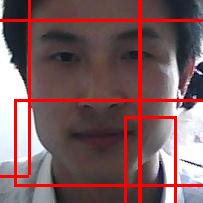

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image, ImageDraw

def apply_regression(img_path, reg_out):
    # Load the input image
    img = Image.open(img_path).convert("RGB")

    # Get the dimensions of the input image
    width, height = img.size

    # Create a new image with the same dimensions as the input image
    new_img = Image.new("RGB", (width, height), color="white")

    # Draw the input image on the new image
    new_img.paste(img)

    # Loop through each output box
    for i in range(reg_out.shape[0]):
        # Get the output box coordinates
        x1, y1, x2, y2 = reg_out[i]

        # Scale the box coordinates to the size of the input image
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Draw the box on the new image
        draw = ImageDraw.Draw(new_img)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display the new image with bounding boxes
    new_img.show()

# Define the example input image and regression output
img_path = '/content/drive/MyDrive/detect/detect_train/ClientFace/0001/0001_00_00_01_0.jpg'
reg_out = torch.randn(8, 4)

# Call the function to apply the regression output to the input image and display the result
apply_regression(img_path, reg_out)


antispoof


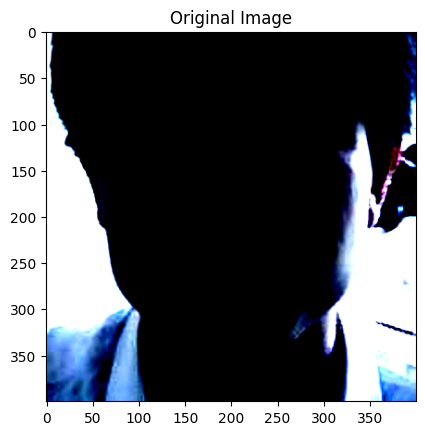

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 100 * 100, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

# Load the contour mask
mask_shape = [8, 1, 7, 7]
mask = torch.zeros([1, 1, 8, 6])
mask[0, 0, 1:7, 1] = 1
mask[0, 0, 1:7, 4] = 1
mask[0, 0, 1, 1:5] = 1
mask[0, 0, 6, 1:5] = 1
mask[0, 0, 0, 0] = 1
mask[0, 0, 0, 5] = 1
mask[0, 0, 7, 0] = 1

# Define the function to preprocess the input image
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((400, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img.unsqueeze(0)

# Define the function to detect whether the input image is a spoofed or antispoofed image
def detect_spoofed_image(model, img_path, mask):
    img = preprocess_image(img_path)
    # Resize the mask to match the size of the input image
    mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
    masked_img = img * mask_resized
    with torch.no_grad():
        output = model(masked_img)
    prediction = torch.argmax(output, dim=1)
    if prediction == 1:
      mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
      masked_img = img * mask_resized
      # Display the contour mask
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      plt.figure()
      plt.title('Contour Mask')
      plt.imshow(masked_img.squeeze(0).permute(1, 2, 0), cmap='gray')
      plt.show()
      return 'spoof', masked_img
    else:
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      return 'antispoof',None
# Test the function on an example input image
img_path = '/content/drive/MyDrive/detect/detect_train/ClientFace/0001/0001_00_00_01_0.jpg'
result, masked_img = detect_spoofed_image(model, img_path, mask)
print(result)



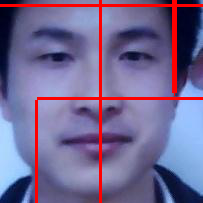

In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image, ImageDraw

def apply_regression(img_path, reg_out):
    # Load the input image
    img = Image.open(img_path).convert("RGB")

    # Get the dimensions of the input image
    width, height = img.size

    # Create a new image with the same dimensions as the input image
    new_img = Image.new("RGB", (width, height), color="white")

    # Draw the input image on the new image
    new_img.paste(img)

    # Loop through each output box
    for i in range(reg_out.shape[0]):
        # Get the output box coordinates
        x1, y1, x2, y2 = reg_out[i]

        # Scale the box coordinates to the size of the input image
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Draw the box on the new image
        draw = ImageDraw.Draw(new_img)
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)

    # Display the new image with bounding boxes
    new_img.show()

# Define the example input image and regression output
img_path = '/content/drive/MyDrive/detect/detect_train/ImposterFace/0001/0001_00_00_01_0.jpg'
reg_out = torch.randn(8, 4)

# Call the function to apply the regression output to the input image and display the result
apply_regression(img_path, reg_out)


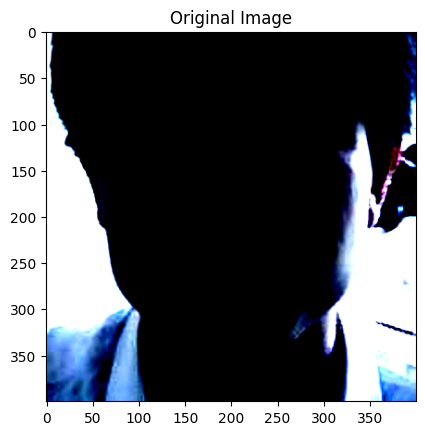

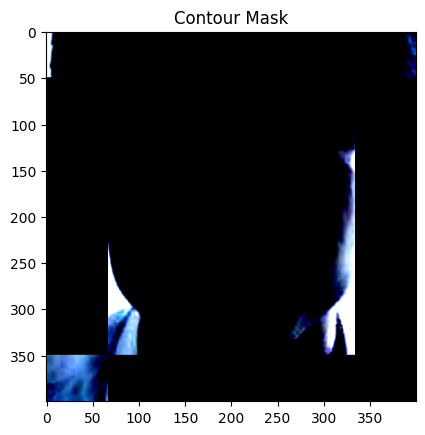

spoof


In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 100 * 100, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 100 * 100)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

# Load the contour mask
mask_shape = [8, 1, 7, 7]
mask = torch.zeros([1, 1, 8, 6])
mask[0, 0, 1:7, 1] = 1
mask[0, 0, 1:7, 4] = 1
mask[0, 0, 1, 1:5] = 1
mask[0, 0, 6, 1:5] = 1
mask[0, 0, 0, 0] = 1
mask[0, 0, 0, 5] = 1
mask[0, 0, 7, 0] = 1

# Define the function to preprocess the input image
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((400, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img.unsqueeze(0)

# Define the function to detect whether the input image is a spoofed or antispoofed image
def detect_spoofed_image(model, img_path, mask):
    img = preprocess_image(img_path)
    # Resize the mask to match the size of the input image
    mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
    masked_img = img * mask_resized
    with torch.no_grad():
        output = model(masked_img)
    prediction = torch.argmax(output, dim=1)
    if prediction == 1:
      mask_resized = torch.nn.functional.interpolate(mask, size=(img.shape[-2], img.shape[-1]), mode='nearest')
      masked_img = img * mask_resized
      # Display the contour mask
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      plt.figure()
      plt.title('Contour Mask')
      plt.imshow(masked_img.squeeze(0).permute(1, 2, 0), cmap='gray')
      plt.show()
      return 'spoof', masked_img
    else:
      plt.title('Original Image')
      plt.imshow(preprocess_image(img_path).squeeze(0).permute(1, 2, 0))
      return 'antispoof',None
# Test the function on an example input image
img_path = '/content/drive/MyDrive/detect/detect_train/ClientFace/0001/0001_00_00_01_0.jpg'
result, masked_img = detect_spoofed_image(model, img_path, mask)
print(result)



In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the classes for the model
classes = ['antispoof', 'spoof']

class SpoofDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(64 * 25 * 25, 128)
        self.fc2 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool2(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SpoofDetector()

In [ ]:
import torch
from torchvision import transforms, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score

# Define the transforms for the input images
preprocess_image = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/detect/detect_val', transform=preprocess_image)

# Define the data loader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the models to be evaluated
models = [SpoofDetector()]

# Evaluate each model on the test dataset
for model in models:
    model.eval()
    with torch.no_grad():
        scores = []
        labels = []
        for images, target in test_dataloader:
            output = model(images)
            scores.append(output[0][1].item())
            labels.append(target.item())
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
        eer = 1 - tpr[np.abs(thresholds - eer_threshold).argmin()]
        predicted_labels = (scores >= eer_threshold).astype(int)

        # Calculate the accuracy, precision, and recall
        accuracy = accuracy_score(labels, predicted_labels)
        precision = precision_score(labels, predicted_labels)
        recall = recall_score(labels, predicted_labels)
        genuine_scores = [scores[i] for i in range(len(scores)) if labels[i] == 0]
        spoof_scores = [scores[i] for i in range(len(scores)) if labels[i] == 1]
        apcer = sum([1 for s in spoof_scores if s < eer_threshold]) / len(spoof_scores)
        bpcer = sum([1 for s in genuine_scores if s >= eer_threshold]) / len(genuine_scores)
        print(f"APCER: {apcer}")
        print(f"BPCER: {bpcer}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")


        print(f"EER: {eer}")
        print(f'{model.__class__.__name__}: ROC AUC = {roc_auc:.2f}')


APCER: 0.13333333333333333
BPCER: 0.12280701754385964
Accuracy: 0.8717948717948718
Precision: 0.8813559322033898
Recall: 0.8666666666666667
EER: 0.1333333333333333
SpoofDetector: ROC AUC = 0.92


**Threshold=0.4**

In [ ]:
import torch
import numpy as np
from torchvision import transforms, datasets
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score

# Define the transforms for the input images
preprocess_image = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test dataset
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/detect/detect_val', transform=preprocess_image)

# Define the data loader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the models to be evaluated
models = [SpoofDetector()]

# Evaluate each model on the test dataset
for model in models:
    model.eval()
    with torch.no_grad():
        scores = []
        labels = []
        for images, target in test_dataloader:
            output = model(images)
            scores.append(output[0][1].item())
            labels.append(target.item())
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc = auc(fpr, tpr)
        eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
        eer = 1 - tpr[np.abs(thresholds - eer_threshold).argmin()]

        # Threshold to apply
        threshold = 0.4

        # Predict labels based on the given threshold
        predicted_labels = (np.array(scores) >= threshold).astype(int)

        # Calculate the accuracy, precision, and recall
        accuracy = accuracy_score(labels, predicted_labels)
        precision = precision_score(labels, predicted_labels)
        recall = recall_score(labels, predicted_labels)
        print(f"Accuracy: {accuracy}")


        # Calculate APCER and BPCER
        genuine_scores = [scores[i] for i in range(len(scores)) if labels[i] == 0]
        spoof_scores = [scores[i] for i in range(len(scores)) if labels[i] == 1]
        apcer = sum([1 for s in spoof_scores if s < threshold]) / len(spoof_scores)
        bpcer = sum([1 for s in genuine_scores if s >= threshold]) / len(genuine_scores)
        print(f"APCER: {apcer}")
        print(f"BPCER: {bpcer}")

        print(f"EER: {eer}")
        print(f"ROC AUC :{roc_auc:.2f}")


Accuracy: 0.48717948717948717
APCER: 1.0
BPCER: 0.0
EER: 0.8333333333333334
ROC AUC :0.14


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
